In [9]:
from io import StringIO

from pathlib import Path
import pandas
import numpy
import matplotlib.pyplot as plt

import pint

ureg = pint.UnitRegistry()

In [10]:
CFS_per_ACRE_to_INHR = (
    (ureg("cubic_feet / second") / ureg("acres")).to("inches / hr").magnitude
)
CFS_per_ACRE_to_INHR

0.9917315702519007

In [2]:
outdir = Path("./nomographs/flow")
outdir.mkdir(parents=True, exist_ok=True)
outdirqa = Path("./qa/flow")
outdirqa.mkdir(parents=True, exist_ok=True)

In [7]:
flow_paths = list(Path("./data/flow").glob("*.csv"))
flow_paths

[WindowsPath('data/flow/1980s_Results.csv'),
 WindowsPath('data/flow/2030s_Results.csv'),
 WindowsPath('data/flow/2050s_Results.csv'),
 WindowsPath('data/flow/2080s_Results.csv')]

In [17]:
def create_met_dataframe() -> pandas.DataFrame:
    string = """
epoch	mean_annual_precip_depth_inches	design_storm_precip_depth_inches	ro_coeff
1980s	35.539	0.652	0.450
2030s	35.982	0.715	0.468
2050s	40.338	0.759	0.495
2080s	38.060	0.800	0.505
"""

    df = pandas.read_table(StringIO(string))

    return df


met = (
    create_met_dataframe().assign(area_acres=1)  # per jamie feldman and sarah welsh
)

In [18]:
met

,epoch,mean_annual_precip_depth_inches,design_storm_precip_depth_inches,ro_coeff,area_acres
0,1980s,35.539,0.652,0.450,1
1,2030s,35.982,0.715,0.468,1
2,2050s,40.338,0.759,0.495,1
3,2080s,38.060,0.800,0.505,1


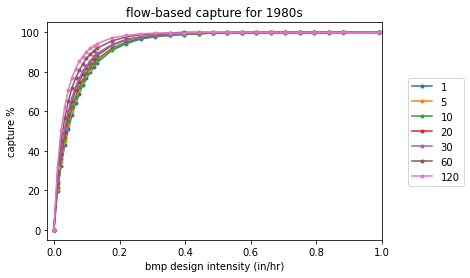

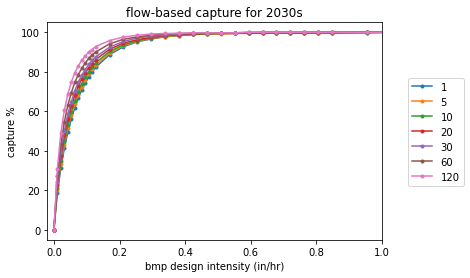

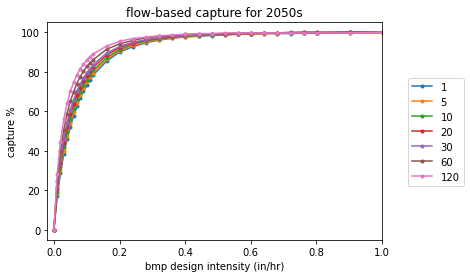

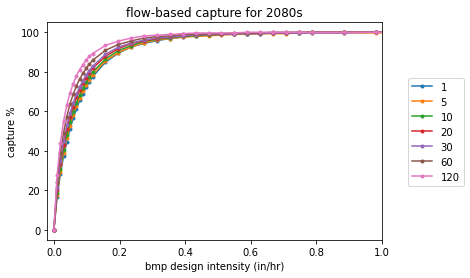

In [22]:
for f, (i, row) in zip(flow_paths, met.iterrows()):
    df = pandas.read_csv(f)
    assert f.stem.split("_")[0] == row.epoch

    eff_area = row.area_acres * row.ro_coeff

    df["flowrate_cfs"] = df["CutoffQ_cfs"]
    df["tc_minutes"] = df["Tc_min"]
    df["intensity_inhr"] = (df["flowrate_cfs"] / eff_area) * CFS_per_ACRE_to_INHR
    df["capture_fraction"] = numpy.clip(df["Capture_Efficiency_%"] / 100, 0, 1.0)

    nulls = df["tc_minutes"].drop_duplicates().to_frame()
    nulls["intensity_inhr"] = 0
    nulls["capture_fraction"] = 0

    df = pandas.concat([df, nulls], ignore_index=True).sort_values(
        ["tc_minutes", "intensity_inhr"]
    )

    out = df.reindex(
        columns=["flowrate_cfs", "intensity_inhr", "tc_minutes", "capture_fraction"]
    ).round(4)

    out.to_csv(outdir / (row.epoch + ".csv"), index=False)
    df.to_csv(outdirqa / (row.epoch + ".csv"), index=False)

    fig, ax = plt.subplots()

    for i, df in out.groupby("tc_minutes"):
        ax.plot(
            df["intensity_inhr"],
            df["capture_fraction"] * 100,
            marker="o",
            ms=3,
            label=i,
        )

    ax.set_title(f"flow-based capture for {row.epoch}")

    ax.set_xlim(-0.02, 1)
    ax.set_ylabel("capture %")
    ax.set_xlabel("bmp design intensity (in/hr)")

    fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.5))

    # fig.savefig(outdirqa / (row.epoch + ".png"), dpi=300, bbox_inches='tight')